In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data, models
import json
import torch

In [4]:
############################################
sweep_root = "../../results/sweep-emb"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"
mt = models.load_model(model_name, fp16=True, device="cuda")

In [11]:
dataset = data.load_dataset()
relation = dataset.filter(
    relation_names=["company CEO"]
)[0]

In [13]:
from src.sweeps import (
    SweepRelationResults,
    SweepTrialResults,
    SweepLayerResults,
    SweepTrainResults,
    SweepBetaResults, SweepRankResults,
)

def parse_results(sweep_result):
    relation_results = SweepRelationResults(
        relation_name=sweep_result["relation_name"],
        trials = []
    )

    for trial in sweep_result["trials"]:
        trial_results = SweepTrialResults(
            prompt_template=trial["prompt_template"],
            train_samples=trial["train_samples"],
            layers = []
        )
        for layer in trial["layers"]:
            train_results = SweepTrainResults(
                samples = layer["result"]["samples"],
                betas = [],
                ranks = [],
                jh_norm=layer["result"]["jh_norm"],
            )
            for beta in layer["result"]["betas"]:
                beta_results = SweepBetaResults(
                    beta = beta["beta"],
                    recall = beta["recall"]
                )
                train_results.betas.append(beta_results)

            for rank in layer["result"]["ranks"]:
                rank_results = SweepRankResults(
                    rank = rank["rank"],
                    efficacy = rank["efficacy"]
                )
                train_results.ranks.append(rank_results)
            
            layer_results = SweepLayerResults(
                layer=layer["layer"],
                result=train_results
            )

            trial_results.layers.append(layer_results)
        relation_results.trials.append(trial_results)
    return relation_results


sweep_results = {}

for relation_folder in os.listdir(sweep_path):
    cur_sweep = f"{sweep_path}/{relation_folder}"
    if len(os.listdir(cur_sweep)) < 3:
        continue
    with open(f"{cur_sweep}/results_all.json") as f:
        res = json.load(f)["relations"]
        if(len(res) == 0):
            continue
        res = res[0]
        sweep_results[res["relation_name"]] = res

In [17]:
relation_results = parse_results(sweep_results[relation.name])
best_by_faithfulness = relation_results.best_by_faithfulness()
best_by_faithfulness

SweepLayerSummary(layer=5, beta=AggregateMetric(mean=0.350000003973643, stdev=0.24832774362951052, stderr=0.14337208963175027, values=[0.5, 0.550000011920929, 0.0]), recall=AggregateMetric(mean=0.27777777777777773, stdev=0.07856742013183861, stderr=0.045360921162651446, values=[0.3333333333333333, 0.3333333333333333, 0.16666666666666666]), rank=AggregateMetric(mean=106.66666666666667, stdev=33.9934634239519, stderr=19.62613525850633, values=[120, 140, 60]), efficacy=AggregateMetric(mean=0.7222222222222223, stdev=0.15713484026367724, stderr=0.0907218423253029, values=[0.8333333333333334, 0.8333333333333334, 0.5]), jh_norm=AggregateMetric(mean=44.91138712565104, stdev=4.086115724671423, stderr=2.359120013579009, values=[47.710384368896484, 39.1336784362793, 47.890098571777344]))

In [19]:
h_layer = best_by_faithfulness.layer
beta = best_by_faithfulness.beta.mean

In [95]:
from src.sweeps import(
    DEFAULT_RECALL_K,
    DEFAULT_N_TRIALS,
    DEFAULT_N_TRAIN_SAMPLES
)
from src.functional import compute_hs_and_zs, random_edit_targets, low_rank_approx
from src.operators import JacobianIclMeanEstimator, LinearRelationOperator
from src import editors
from src import metrics


In [98]:
def calculate_faithfulness(
    operator, test_subjects, test_objects, test_hs, verbose = False
):
    pred_objects = []
    for subj, h in zip(test_subjects, test_hs):
        preds = operator(subj, h=h, k=DEFAULT_RECALL_K)
        if(verbose):
            pred = str(preds.predictions[0])
            print(f"reading {h_layer=} {beta=} {subj=} {pred=}")
        pred_objects.append([p.token for p in preds.predictions])
    recall = metrics.recall(pred_objects, test_objects)
    return recall

In [108]:
rank_sweep = list(range(0, models.determine_hidden_size(mt)+1, 16))
trial_recalls = {
    rnk: [] for rnk in rank_sweep
}

for trial in range(DEFAULT_N_TRIALS):
    print(f"trial {trial+1}/{DEFAULT_N_TRIALS}")

    train, test = relation.split(train_size=DEFAULT_N_TRAIN_SAMPLES)

    # Precompute all the hs to speed things up.
    hs_by_subj, zs_by_subj = compute_hs_and_zs(
        mt=mt,
        prompt_template=relation.prompt_templates[0],
        subjects=[x.subject for x in relation.samples],
        h_layer=h_layer,
        z_layer=-1,
        batch_size=16,
        examples=train.samples,
    )

    test_samples = test.samples
    test_subjects = [x.subject for x in test_samples]
    test_hs = [hs_by_subj[x.subject][None] for x in test_samples]
    test_objects = [x.object for x in test_samples]

    estimator = JacobianIclMeanEstimator(
        mt=mt,
        h_layer=h_layer, beta = beta
    )

    operator = estimator(
        relation.set(
            samples=train.samples,
            prompt_templates=[train.prompt_templates[0]],
        )
    )
    print("full rank faithfullness")
    weight_orig = operator.weight.clone()

    recall = calculate_faithfulness(
        operator=operator,
        test_subjects=test_subjects,
        test_objects=test_objects,
        test_hs=test_hs,
        verbose=True
    )
    print(f"reading finished rank=FULL, {operator.weight.norm()} {recall[0]=:.2f}")
    print()

    for rank in rank_sweep:
        weight_low_rank = low_rank_approx(matrix = weight_orig, rank=rank)
        operator.weight[:] = weight_low_rank
        recall = calculate_faithfulness(
            operator=operator,
            test_subjects=test_subjects,
            test_objects=test_objects,
            test_hs=test_hs,
            verbose=False
        )
        print(f"reading finished {rank=}, weight_norm={operator.weight.norm()}, dist={torch.dist(weight_orig, operator.weight)} {recall[0]=:.2f}")
        trial_recalls[rank].append(recall)

trial 1/3
full rank faithfullness
reading h_layer=5 beta=0.350000003973643 subj='Microsoft' pred=' Sat (p=0.628)'
reading h_layer=5 beta=0.350000003973643 subj='Citigroup' pred=' Charles (p=0.074)'
reading h_layer=5 beta=0.350000003973643 subj='Goldman Sachs' pred=' Lloyd (p=0.398)'
reading h_layer=5 beta=0.350000003973643 subj='Tesla' pred=' Elon (p=0.955)'
reading h_layer=5 beta=0.350000003973643 subj='Saudi Aramco' pred=' Warren (p=0.398)'
reading h_layer=5 beta=0.350000003973643 subj='JPMorgan Chase' pred=' Hugh (p=0.034)'
reading h_layer=5 beta=0.350000003973643 subj='NVIDIA' pred=' NVIDIA (p=0.326)'
reading h_layer=5 beta=0.350000003973643 subj='Alphabet' pred=' Google (p=0.199)'
reading h_layer=5 beta=0.350000003973643 subj='Johnson & Johnson' pred=' Johnson (p=0.144)'
reading h_layer=5 beta=0.350000003973643 subj='General Motors' pred=' GM (p=0.164)'
reading h_layer=5 beta=0.350000003973643 subj='Apple' pred=' Apple (p=0.325)'
reading h_layer=5 beta=0.350000003973643 subj='Meta

In [110]:
recalls = [
    metrics.AggregateMetric.aggregate([
        r[0] for r in recall
    ]) for rank, recall in trial_recalls.items()
]

Text(0.5, 1.0, 'company CEO\nh_layer=5, beta=0.350')

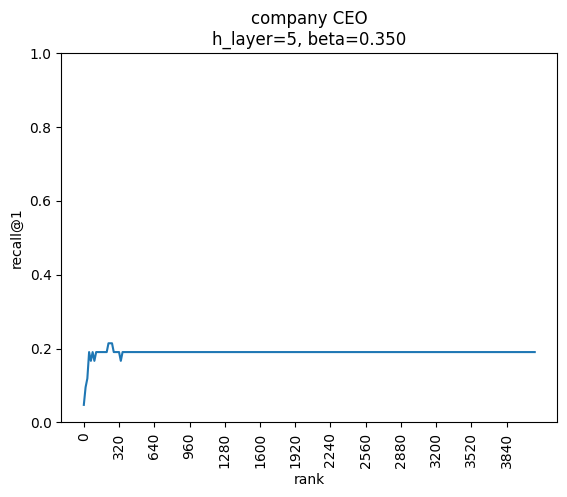

In [132]:
plt.plot([r.mean for r in recalls])
plt.xticks(range(0, len(recalls), 20), rank_sweep[::20], rotation = 90)
plt.ylim(0, 1)
plt.xlabel("rank")
plt.ylabel("recall@1")
plt.title(f"{relation.name}\nh_layer={h_layer}, beta={beta:.3f}")

In [41]:
svd = torch.svd(operator.weight.float())

In [40]:
test_targets = random_edit_targets(test_samples)

editor = editors.LowRankPInvEditor(
    lre=operator,
    rank=100,
    n_samples=1,
    n_new_tokens=1,
    svd=svd,
)

pred_objects = []
targ_objects = []
for sample in test_samples:
    target = test_targets.get(sample)
    if target is None:
        print(f"cannot edit {target}, skipping")
        continue

    z_original = zs_by_subj[sample.subject]
    z_target = zs_by_subj[target.subject]
    result = editor(
        sample.subject,
        target.subject,
        z_original=z_original,
        z_target=z_target,
    )

    pred = str(result.predicted_tokens[0])
    print(
        f"editing: {h_layer=} {rank=} {sample.subject=} {target.subject=} {pred=}"
    )

    pred_objects.append([result.predicted_tokens[0].token])
    targ_objects.append(target.object)

[efficacy] = metrics.recall(pred_objects, targ_objects)
print(f"editing finished: {h_layer=} {rank=} {efficacy=:.2f}")

editing: h_layer=5 rank=100 sample.subject='Johnson & Johnson' target.subject='Microsoft' pred=' Sat (p=0.981)'
editing: h_layer=5 rank=100 sample.subject='Citigroup' target.subject='Johnson & Johnson' pred=' Mark (p=0.077)'
editing: h_layer=5 rank=100 sample.subject='Apple' target.subject='Tesla' pred=' Tim (p=0.737)'
editing: h_layer=5 rank=100 sample.subject='Alphabet' target.subject='Berkshire Hathaway' pred=' Warren (p=0.292)'
editing: h_layer=5 rank=100 sample.subject='China Construction Bank' target.subject='General Motors' pred=' Daniel (p=0.137)'
editing: h_layer=5 rank=100 sample.subject='Nasdaq' target.subject='JPMorgan Chase' pred=' James (p=0.366)'
editing: h_layer=5 rank=100 sample.subject='Tesla' target.subject='Apple' pred=' Tim (p=0.754)'
editing: h_layer=5 rank=100 sample.subject='Berkshire Hathaway' target.subject='Tesla' pred=' Warren (p=0.829)'
editing: h_layer=5 rank=100 sample.subject='Amazon' target.subject='Apple' pred=' Tim (p=0.684)'
editing: h_layer=5 rank=1